<a href="https://colab.research.google.com/github/land0nevans/MyFirstRepo/blob/main/Green_space_accessibility_in_Birmingham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spatial inequality in access to green space in Birmingham, UK.



* **Authors:** Landon Evans

* **Student ID:** 220016532

* **Date:** 10/12/25


**Abstract:**

Urban green space are essential areas in cities providing a range of social, environmental and health benefits, however are often distributed unevenly. This study uses Birmingham, United Kingdom as an example to investigate the relationship between green space accessibility and social deprivation at the Lower Super Output Area (LSOA) level.

**Keywords:** birmingham, IMD, deprivation, greenspace, greenspace accessibility, spatial inequality, qgis, k-means, DBSCAN, python

# GitHub Repository
- **GitHub Link:** [Add here the link to your repo]

## Declaration

> In submitting this assignment, I hereby confirm that I have read the University's statement on Good Academic Practice. The following work is my own. Significant academic debts and borrowings have been properly acknowledged and referenced.


**Table of Contents:**

* Introduction
* Background on Birmingham, UK
* QGIS Multi-Criteria Evaluation
* Python (DBSCAN and K-means clustering)
* Results
* Discussion
* Limitations
* Conclusion + References




## Introduction

Urban green spaces are essential in cities, providing a wide range of ecological, environmental and cultural benefits as well as improving human wellbeing and conserving biodiversity (Paudel, 2023). Urban green space has also been found to have positive impacts on physical and mental health and exercise, providing open, accessible spaces for physical activity in urban and city areas where there is limited access to open countryside, which is especially true across Birmingham, a major UK city with a considerably high population density compared to the rest of England (Lee et al., 2015)(World Population Review, 2024).

However, accessible green space is often unequally distributed in urban areas, and disproportionately impacts deprived and minority communities (Layton, 2025). This makes Birmingham an excellent study area, as it has clear socio-economic contrasts between LSOAs and ranges from dense inner-city areas to wealthier, suburban neighbourhoods. These inequalities can be investigated as the distribution of greenspace is very uneven.

This study uses QGIS and Multi-Criteria Evaluation (MCE) to create an 'accessibility index' for green space by LSOA. This index is then used in python through DBSCAN and K-means clustering to identify any key 'clusters' between an LSOA's green space accessibilty score and its ranking in the Index of Multiple Deprivation. This approach visualizes greenspace and patterns in areas that are already disadvantaged and will continue to be disadvantaged by lack of access to quality green space.


## Methodology

This report will be split into two main methods:


*   QGIS Multi-Criteria Evaluation (MCE)
*   Python (DBSCAN and K-means clustering analysis)



## A) QGIS Multi-Criteria Evaluation

This MCE was performed to produce a measurable score for greenspace accessibility in each LSOA of Birmingham, referred to as a 'Green Space Accessibility Index'. The two main criterion were Proximity and Walkability; A proximity raster was generated from the green space polygon shapefile and a 350m buffer around each LSOA centroid was created, to represent the reality of 'accessibility' in crowded urban areas (Ordnance Survey, 2025). As the study area is very large, I used this buffer to simulate whether residents of an LSOA could, generally, access the green area by foot or bike.

Each of these criterion were normalised from 0-1, and weighted at 50% each in the equation :

$GSAI = (0.5 * C1) + (0.5 * C2$)

This process generated a score from 0-1, which was then paired with the LSOA polygon in a new column and exported for use in python clustering analysis.
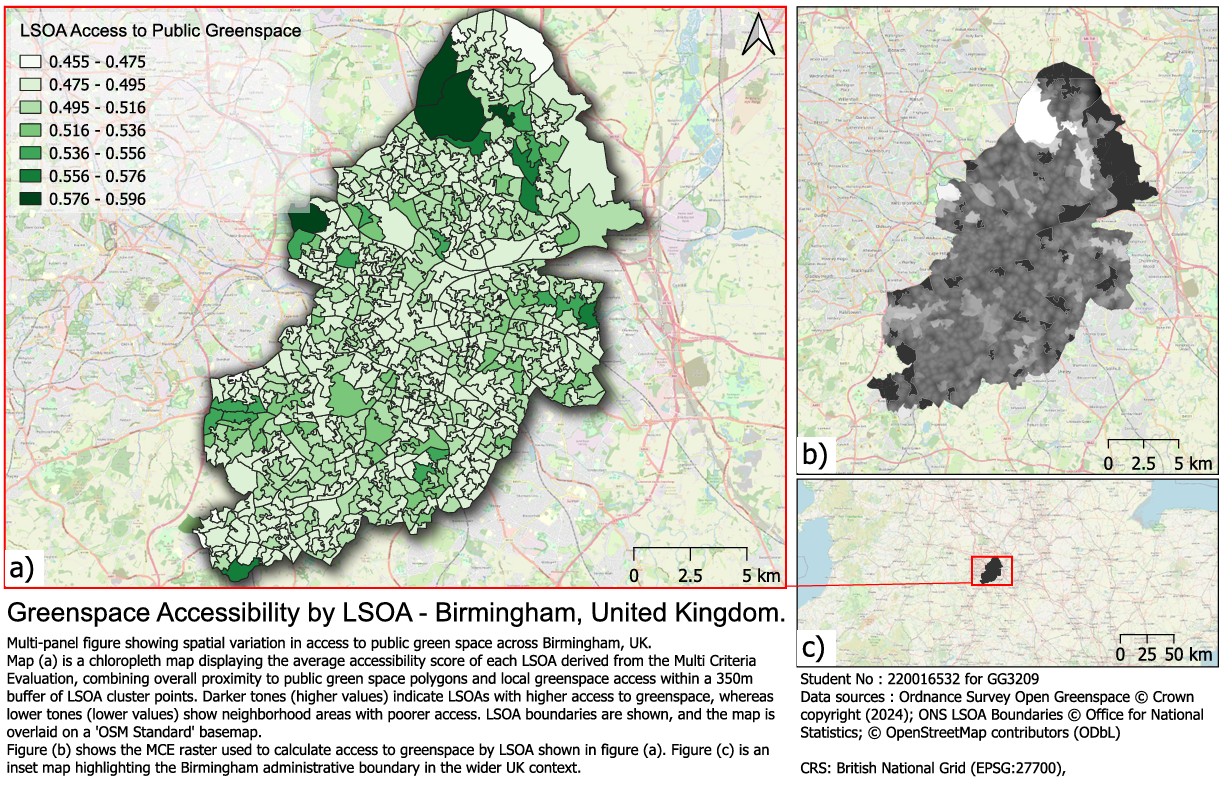

#B) Python analysis
##i) DBSCAN Clustering
DBSCAN clustering identifies areas of closely packed data points into dense 'clusters', and classifying other, low-density points as 'noise'. It defines clusters as areas with many 'neighbours' and is well-suited to spatial analysis (Esri, 2025). It is an unsupervised and fast clustering method and can be controlled by changing parameters such as the 'eps' (radius) and minimum sample number. In this analysis, I used the GSAI value (as a result of part A) and the Multiple Deprivation Index data for Birmingham (Birmingham City Council, 2025). This was joined to the LSOA shapefile, by the LSOA21CD column. I implemented DBSCAN clustering to compare this green space accessibility 'score' to an LSOA's IMD ranking, to identify any clusters of similarity (e.g, lower deprivation + lower accessibility).

Several parameter combinations were tested to limit data points being classified as 'noise', with the most understandable parameters being eps = 0.2 and min_samples = 5. This combination identified several clusters and a general 'neighbourhood' radius, as the data was spread across the entirety of Birmingham. As I was using a standardised green space accessibility score (column 'GSAI_mean'), I standardised the IMD ranking from 0-1 before performing my analysis using the 'StandardScaler' as part of the scitkit-learn library (SciKit, 2025).

To prepare this dataset, I renamed the columns to much shorter names and converted them to numerical values. I also subsetted the dataset to drop unnecessary columns as a result of joining my QGIS geopackage to the IMD csv, as well as any missing values in the columns I would be using for analysis to prevent issues in the DBSCAN algorithm.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

original_path ="/Users/l4nd0/Desktop/3209project/python/LSOA_GSAI_IMD_FINAL.gpkg" # this has been included as I worked locally, but compiled into Colab.
path = "/content/drive/MyDrive/LSOA_GSAI_IMD_FINAL.gpkg"  # edited path for google colab.
gdf = gpd.read_file(path)

IMD_RANK_ORIG = "imd-indices-of-deprivation-2025-wmca-lsoa-2021_Index of Multiple Deprivation (IMD) Rank"
IMD_DECILE_ORIG = "imd-indices-of-deprivation-2025-wmca-lsoa-2021_Index of Multiple Deprivation (IMD) Decile"

gdf["IMD_rank"] = pd.to_numeric(gdf[IMD_RANK_ORIG], errors="coerce") # uses pandas to convert data to numeric when possible, as this raised issues later.
gdf["IMD_decile"] = pd.to_numeric(gdf[IMD_DECILE_ORIG], errors="coerce")

# renaming columns for consistency.
GSAI_COL     = "GSAI_mean"
IMD_RANK_COL = "IMD_rank"
IMD_DECILE_COL = "IMD_decile"

# subsetting geodataframe, keeping the GSAI score, relevant IMD columns and original geometry.
gdf_sub = gdf[[GSAI_COL, IMD_RANK_COL, IMD_DECILE_COL, "geometry"]]
# removing any rows with missing data.
gdf_sub = gdf_sub.dropna(subset=[GSAI_COL, IMD_RANK_COL])
# sets 'X' as a NumPy array suitable for DBSCAN. This is a 2d array using the IMD rank and GSAI score.
X = gdf_sub[[GSAI_COL, IMD_RANK_COL]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
# setting parameters for DBSCAN.
eps = 0.2
min_samples = 5

# runs DBSCAN, assigning to cluster or noise.
db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

# creates new column for the DBSCAN values.
gdf_sub["dbscan_cluster"] = labels

##ii) K-means Clustering
K-means clustering is another unsupervised method which assigns data points to a specified number of clusters (e.g k=4), assigning groups based on similarity between points. This is often used in spatial analysis as it can identify broader patterns in areas where boundaries are not clearly defined (Kaggle, 2025). I used K-means to identify clusters between an LSOA's Green space accessibility value and its IMD ranking.

I generated centroids from the LSOA polygons and reprojected them to the correct CRS, as this makes cluster visualization clearer and allows for interactive folium maps. To ensure I could create scatter graphs, I created columns for the longitude and latitude coordinates of these centroids.

I chose a k value of 4, to explore simple levels of connection between deprivation and green space accessibility, e.g very low, low, moderate and high. K-means clustering was implemented alongside DBSCAN to demonstrate how different clustering models use the data, and I found that it was far more effective to visualize relationships between deprivation and green space accessibility. As I was already using scikit learn for normalisation, I found that I could use n_init="auto" to run several initial centroid seeds and use the best output it finds (SciKit, 2019).

In [27]:
# generates centroids from LSOA polygons for easier visualization.
gdf_centroid = gdf_sub
gdf_centroid["geometry"] = gdf_centroid.geometry.centroid
# ensuring correct projection for interactive maps
gdf_points = gdf_centroid.to_crs(epsg=4326)

# creating lon and lat columns from coordinate data
gdf_points["lon"] = gdf_points.geometry.x
gdf_points["lat"] = gdf_points.geometry.y

In [55]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")

# sets 'X' as a NumPy array suitable for Kmeans.
X_kmeans = gdf_points[[GSAI_COL, IMD_RANK_COL]].values
# normalises kmeans using the same scaler in previous DBSCAN code.
X_scaled_kmeans = scaler.fit_transform(X)
labels_kmeans = kmeans.fit_predict(X_scaled_kmeans)
# adds kmeans column, assigning a cluster type to each LSOA.
gdf_points["kmeans_k4"] = labels_kmeans
gdf_sub["kmeans_k4"] = gdf_points["kmeans_k4"].values


## Results

For this results section, I will include figures as images and provide a caption, please see appendix for the code used to produce the figures.


##1. Spatial Distribution of Accessibility to Green Space.

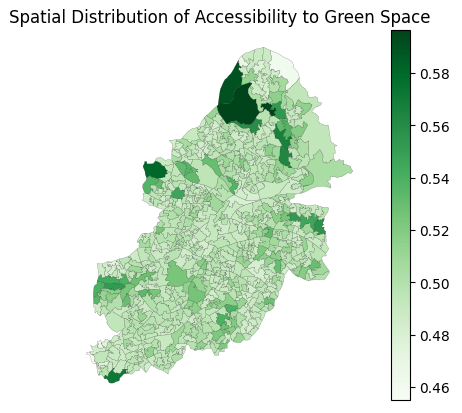
#####*Figure 1. Map showing spatial distribution of Green Space Accessibility (GSAI) as a result of the MCE across Birmingham, UK.*

#####This map reveals that the highest accessibility values are found in Northern Birmingham, with a large dark green area showing 'Sutton Park' in Sutton Coldfield. Central Birmingham, however, show much lower access to green space and is to be expected of a much more dense urban city space. While inner-city areas are more densely populated, areas of North and East Birmingham are suburban, open, green areas.

##2. Relationship between LSOA deprivation and access to green space.

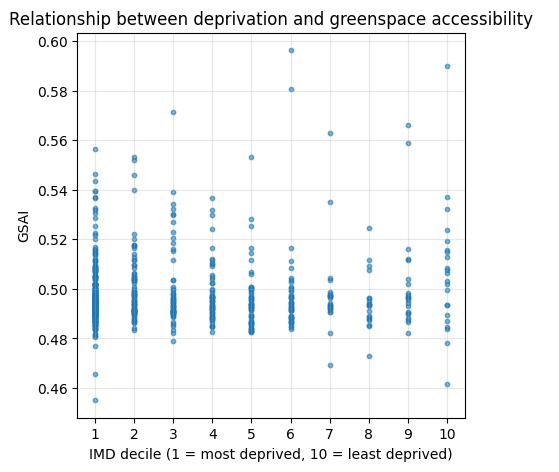
#####*Figure 2. Scatterplot showing relationship between Green Space Accessibility (GSAI) and IMD decile in Birmingham, UK.*

#####This scatterplot shows no clear link between deprivation and GSAI, although there are slightly lower GSAI scores for the lowest deciles (1-3), there is a lot of overlap between each deprivation decile and suggests that variations in green space accessibility cannot be explained by deprivation ranking alone.

##3. DBSCAN + Kmeans clustering maps

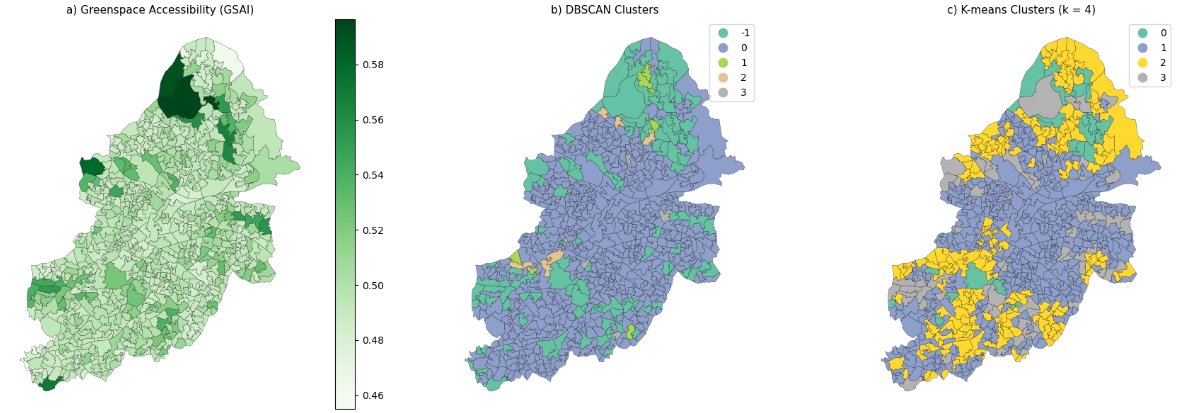
#####*Figure 3. A 3 panel figure showing maps displaying the spatial distribution of GSAI alongside DBSCAN and K-means clustering results.*

#####This combined figure shows the differences between DBSCAN and K-means clustering algorithms, with DBSCAN failing to show any particular dense cluster areas whereas K-means shows much clearer distinction between neighbourhood types, especially in North Birmingham and separating more suburban neighbourhoods to the North and South of central, urban Birmingham.

## Discussion

From Figure 1, it is clear that there are significant inequalities in access to green space across Birmingham, as areas in the North (notably Sutton Coldfield) and South of the study area have higher access to greenspace on average. From the chloropleth map, there is a general trend of increasing accessibility to greenspace the further away from the city centre, as 'pockets' of high accessibility emerge on the West and East boundaries of the Birmingham area. This aligns with expectations as inner-city areas are typically more densely populated in England and Wales compared to countryside areas. In Birmingham, some inner-city areas have populations of over 10,000 per km2 while other areas average around 100-250 per km2 (Plumplot, 2021). This suggests a substantial lack of housing space, and this may be prioritised over green space in urban planning. The results of this chloropleth also align with the hotspots identified as part of Birmingham's 'City of Nature' plan, to increase accessibility to green space across the next 25 years. The six key focus areas (Balsall Heath West, Bordesley & Highgate, Nechells, Gravelly Hill, Pype Hayes, and Castle Vale) identified in this plan are clearly shown on the GSAI map, but this general overview of accessibility may be useful in wider city-planning efforts (Birmingham City Council, 2015).


The scatterplot in Figure 2 shows that there is a relatively weak or unclear relationship between deprivation and GSAI across Birmingham. In general, the lowest IMD deciles (1-3) show slightly lower GSAI values on average, but the data is very spread within each decile showing high levels of internal variation. Many deprived areas have higher accessibility scores than lesser deprived neighbourhoods, but less deprived areas (higher decile) do not strongly demonstrate high accessibility. Many LSOAs cluster around the city average, suggesting that deprivation alone does not have a particularly strong relationship with green space access.

Figure 3 shows that DBSCAN clustering results do not form many isolated or meaningful clusters, apart from successfully identifying areas with higher access to green space. There are 3 notable clusters, with cluster 1 showing high green space accessibility and low deprivation scores (visible in North suburban areas of Sutton Coldfield), cluster 2 shows dispersed neighbourhoods where access is comparatively lower to surrounding areas, and cluster 3 shows LSOAs where there are high levels of deprivation but above average access to green space. Though, the vast majority of LSOAs are classified as 'noise'. This result may suggest that urban equality trends are more transitional across the study area (e.g the further away from the city centre) rather than 'hotspots' of disadvantaged LSOAs.

However, as shown in map 3, K-means clustering provided a much more meaningful map and was able to correctly classify neighbourhood types. Compared to the DBSCAN result, there are clearer gradients as this identifies broader patterns compared to anomalies. Similarly, one cluster identifies areas with high deprivation and low green space access, one with high levels of access and moderate deprivation, and the main cluster showing areas with moderate deprivation and moderate access. The K-means result also identifies suburban areas (in the North) with low deprivation and higher accessibility.

These maps clearly show that access to greenspace is not evenly distributed, and should be a priority in future city-planning. There is a complex spatial relationship between deprivation and GSAI, there are some key deprived areas with low green space access, but this pattern is not quite universal. Similarly, there are some areas of lower deprivation that still have below average access to green space. It is important to recognise that central Birmingham has a lower deprivation score, as it is a business hub and there are several affluent pockets. In general, the more deprived areas are in the 'inner ring' around the city centre. K-means clustering captures the broader patterns in the deprivation and GSAI relationship, whereas DBSCAN can detect a few anomalous LSOAs. From this study, it is clear that deprivation alone does not explain disparities in green space accessibility. Instead, it is important to identify these key risk areas to target future interventions and introduce safe, accessible areas of green space.

## Conclusion

This report explored the spatial inequalities in public green space access across Birmingham using a multi-criteria evaluation conducted in QGIS and clustering methods to identify key patterns. A green space accessibility score (or index) was produced considering proximity-based accessibility within a 350m buffer around LSOA centroids and general distance from green space polygons. This was visualised and revealed clear spatial variation across the study area. North and South areas of Birmingham had the highest access scores, driven by large parks while inner-city neighbourhoods and densely built-up areas showed consistently low access.

There was not a linear relationship between deprivation and green space accessibility, as the scatterplot showed a weak relationship between IMD decile and GSAI score, with strong variation in each decile. Therefore deprivation alone does not predict green space accessibility in Birmingham, but can reveal some spatial patterns in deprived areas and limited accessibility reinforcing the need for targeted intervention in these neighbourhoods, as outlined in the 'City of Nature' plan for Birmingham.

The methods used in this study were somewhat effective in capturing general, broad patterns and anomalous 'clusters' in green space access. The combination of these methods provides a more detailed understanding of these relationships instead of just using one method, but it is important to mention that this study does not consider the quality of green space and other social issues. For example, areas with high crime rates may mean that green space is unsafe for residents and is therefore not as 'accessible' as implied. The MCE also relied on Euclidean distance, and does not consider mobility patterns or transport in each LSOA. Future research may benefit from considering a wider range of network-based metrics to understand the real-world experience of access to green space.

## Appendix



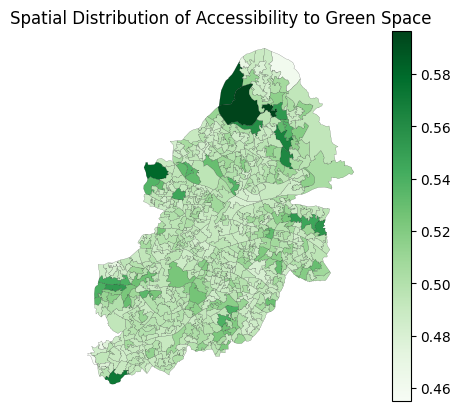

In [57]:
#Figure 1
spatial_dis = gdf_sub.plot(
    column=GSAI_COL,
    legend=True,
    cmap="Greens",
    edgecolor="black",
    linewidth=0.1
)
spatial_dis.set_title("Spatial Distribution of Accessibility to Green Space")
spatial_dis.set_axis_off()


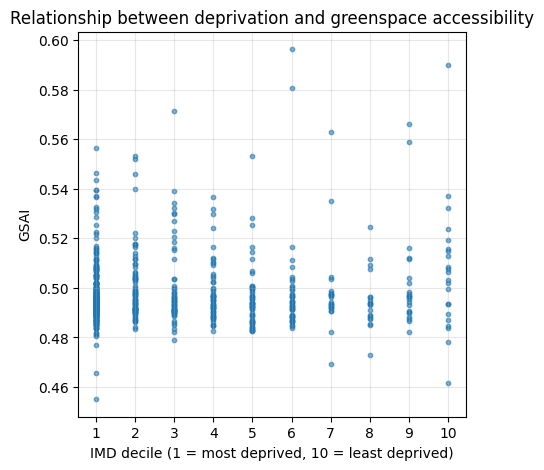

In [59]:
#Figure 2
plt.figure(figsize=(5,5))
plt.scatter(
    gdf_sub[IMD_DECILE_COL],
    gdf_sub[GSAI_COL],
    s=10,
    alpha=0.6
)
plt.xlabel("IMD decile (1 = most deprived, 10 = least deprived)")
plt.ylabel("GSAI")
plt.title("Relationship between deprivation and greenspace accessibility")
plt.grid(alpha=0.3)
plt.xticks(range(1, 11))
plt.show()

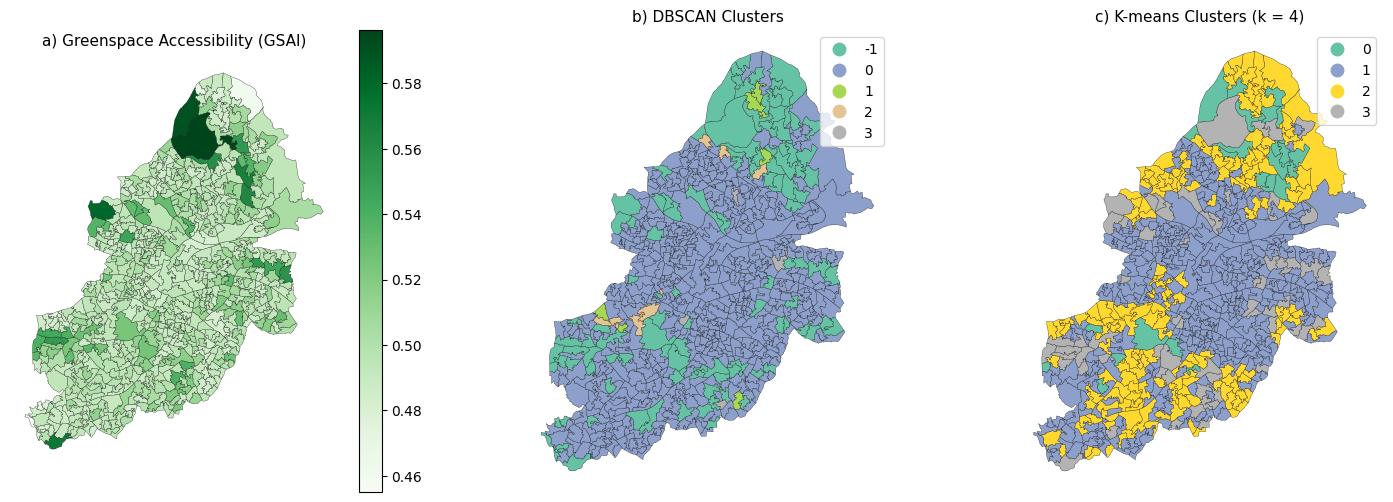

In [67]:
#Figure 3

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

gdf_sub.plot(
    column=GSAI_COL,
    ax=axes[0],
    legend=True,
    cmap="Greens",
    edgecolor="black",
    linewidth=0.2
)
axes[0].set_title("a) Greenspace Accessibility (GSAI)", fontsize=11)
axes[0].set_axis_off()

gdf_sub.plot(
    column="dbscan_cluster",
    categorical=True,
    legend=True,
    cmap="Set2",
    ax=axes[1],
    edgecolor="black",
    linewidth=0.2
)
axes[1].set_title("b) DBSCAN Clusters", fontsize=11)
axes[1].set_axis_off()


gdf_sub.plot(
    column="kmeans_k4",
    categorical=True,
    legend=True,
    cmap="Set2",
    ax=axes[2],
    edgecolor="black",
    linewidth=0.2
)
axes[2].set_title("c) K-means Clusters (k = 4)", fontsize=11)
axes[2].set_axis_off()

plt.show()

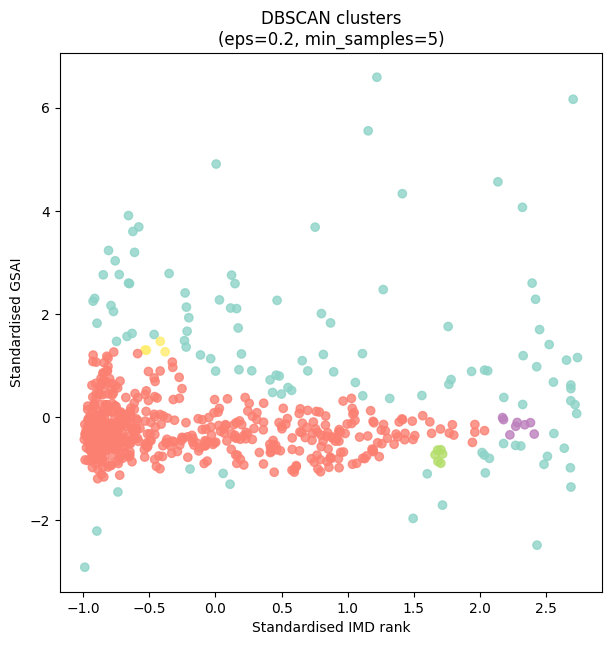

In [72]:
#Figure 4
fig, dbscan_scatter = plt.subplots(figsize=(7, 7))
scatter = dbscan_scatter.scatter(
    X_scaled[:, 1],   # standardised IMD rank
    X_scaled[:, 0],   # standardised GSAI
    c=labels,
    cmap="Set3",
    alpha=0.8
)

dbscan_scatter.set_title(f"DBSCAN clusters\n(eps={eps}, min_samples={min_samples})")
dbscan_scatter.set_xlabel("Standardised IMD rank")
dbscan_scatter.set_ylabel("Standardised GSAI")

plt.show()


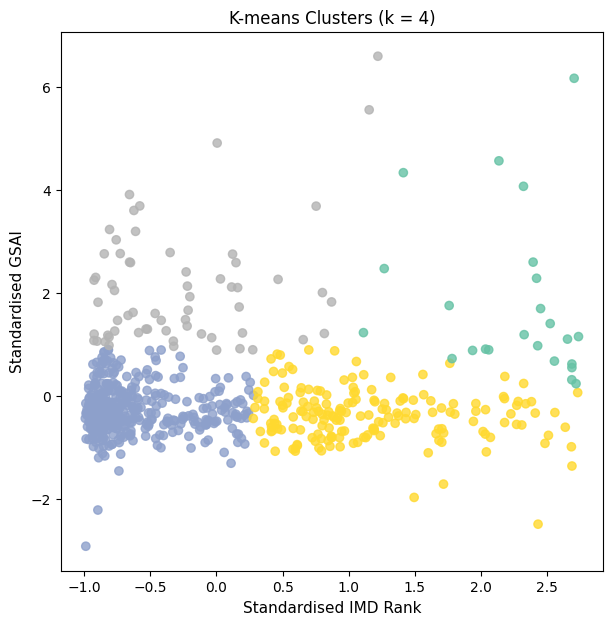

In [71]:
#Figure 5
fig, ax = plt.subplots(figsize=(7, 7))
kmeans_labels = kmeans.predict(X_scaled)
scatter = ax.scatter(
    X_scaled[:, 1],
    X_scaled[:, 0],
    c=kmeans_labels,
    cmap="Set2",
    alpha=0.8
)

ax.set_title("K-means Clusters (k = 4)", fontsize=12)
ax.set_xlabel("Standardised IMD Rank", fontsize=11)
ax.set_ylabel("Standardised GSAI", fontsize=11)

plt.show()

## References





*   Birmingham City Council (2015). Birmingham’s City of Nature Plan | Birmingham’s City of Nature plan | Birmingham City Council. [online] Birmingham.gov.uk. Available at: https://www.birmingham.gov.uk/info/50273/our_future_city_plan_ofcp/3050/birminghams_city_of_nature_plan.Birmingham City Council (2025).
* IMD: Indices of Deprivation 2025 - WMCA LSOA (2021). [online] Birmingham.gov.uk. Available at: https://cityobservatory.birmingham.gov.uk/explore/dataset/imd-indices-of-deprivation-2025-wmca-lsoa-2021/information/?disjunctive.local_authority_code_2024&disjunctive.local_authority_name_2024 [Accessed 9 Dec. 2025].
* Esri (2025). Density-based Clustering (Spatial Statistics)—ArcGIS Pro | Documentation. [online] Arcgis.com. Available at: https://pro.arcgis.com/en/pro-app/3.4/tool-reference/spatial-statistics/densitybasedclustering.htm.
* Kaggle (2025). Clustering With K-Means. [online] kaggle.com. Available at: https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means.
* Layton, J. (2025). Civic Universities and Green Spaces : Exploring the Current and Potential Impact on the Wellbeing of Local communities, staff, and Students : Evidence Review. [online] Available at: https://eprints.icstudies.org.uk/id/eprint/472/1/Civic-Universities-and-Green-Spaces.pdf.
* Lee, A., Jordan, H. and Horsley, J. (2015). Value of Urban Green Spaces in Promoting Healthy Living and Wellbeing: Prospects for Planning. Risk Management and Healthcare Policy, 8(8), pp.131–137. doi:https://doi.org/10.2147/rmhp.s61654.
* Ordnance Survey (2025). OS Data Hub. [online] Osdatahub.os.uk. Available at: https://osdatahub.os.uk/data/downloads/open/OpenGreenspace.
Paudel, S. and States, S.L. (2023). Urban green spaces and sustainability: Exploring the ecosystem services and disservices of grassy lawns versus floral meadows. Urban Forestry & Urban Greening, [online] 84(127932), p.127932. doi:https://doi.org/10.1016/j.ufug.2023.127932.
* Plumplot (2021). Birmingham population stats in maps and graphs. [online] www.plumplot.co.uk. Available at: https://www.plumplot.co.uk/Birmingham-population.html.
* SciKit (2019). sklearn.cluster.KMeans — scikit-learn 0.21.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.
* SciKit (2025). Demo of DBSCAN clustering algorithm. [online] scikit-learn. Available at: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#example-cluster-plot-dbscan-py [Accessed 9 Dec. 2025].
* World Population Review (2024). Birmingham, United Kingdom Population 2024. [online] Worldpopulationreview.com. Available at: https://worldpopulationreview.com/cities/united-kingdom/birmingham.

